![SE02.png](Figs/SE02.png)

**Welcome!** This is the second notebook in our series on assessing energy system resilience. 

In the [first notebook – SE01_Power_Network_Model.ipynb](SE01_Power_Network_Model.ipynb), the synthetic 2000-bus Texas power network was introduced and visualised.

Now, we take the next step by introducing a hazard:  
This notebook focuses on simulating a windstorm event and analysing its physical impact on the power network.

### **Learning Objectives:** 
By the end of this notebook, you will be able to:
- Understand the key parameters of the windstorm model
- Generate a windstorm scenario with a specific trajectory and intensity profile.
- Visualize the storm's path and impact radius in relation to the power grid's geography

### **List of contents**
- [Introduction to Hazard Modeling](#1.-Introduction-to-Hazard-Modeling)
- [Loading Required Libraries](#2.-Loading-Required-Libraries)
- [Windstorm Model Parameters](#3.-Windstorm-Model-Parameters)
- [Windstorm Scenario Setup for Texas  ](#4.-Windstorm-Scenario-Setup-for-Texas)
    - [Defining Storm Trajectories](#4.1-Defining-Storm-Trajectories)
    - [Visualizing Initial Coordinates](#4.2-Visualizing-Initial-Coordinates)
    - [Visualizing the Storm](#4.3-Visualizing-the-Storm)
- [Appendix: Geographical Distance Calculations](#Appendix:-Geographical-Distance-Calculations)
    - [Distance](#Distance)
    - [Bearing](#Bearing)
    - [Destination Point](#Destination-Point)

### 1. Introduction to Hazard Modeling
Resilience assessment requires understanding how a physical **hazard** (like a windstorm) affects a system's infrastructure. This notebook focuses on modeling the hazard itself
The process involves:
1.  Defining the Hazard: We create a synthetic windstorm with specific characteristics, such as its path (trajectory), size (radius), and intensity (wind speed).
2.  Determining Exposure: We identify which power system assets (e.g., transmission towers, substations) are physically located within the storm's path.

This notebook covers these steps to translate a weather event into a list of affected components, setting the stage for the operational resilience assessment in the final notebook.

### 2. Loading Required Libraries
We begin by importing the necessary Python packages to facilitate the modeling and visualization of the windstorm scenarios

The developed model is capable of simulating a large number of storm scenarios through the generation of large, randomised data sets. For the purposes of this illustration, this notebook explores the application of the model to a specific windstorm event, demonstrating its analytical depth and operational scope in forecasting and analysing windstorm impacts.

The examples presented in this section use two pairs of components:
- Windstorm modelling tools (`Windstorm` engine): We will use these tools to model windstorms
  - `WindConfig` which provides the settings of the windstorms we will model, and comes pre-populated with example information
  - `WindClass` which provides the windstorms modelling functionalities that will be explored below
- Power network modelling tools (`Network` engine): We will use these tools to model the impacts of windstorms on the GB network.
  - `NetworkConfig` which provides the settings used to model power networks, and comes pre-populated with example information
  - `NetworkClass` which provides the power network functionalities that will be explored below

In [1]:
from QRA.engines.WindStorm import WindClass, WindConfig  # Load windstorm modelling tools
from QRA.engines.Network import NetworkConfig, NetworkClass  # Load network modelling tools
import random
import geopandas as gpd
import pandapower as pp
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import matplotlib.pyplot as plt
import pandapower.plotting as plot
import numpy as np
import pandas as pd
from IPython.display import display, HTML

### 3. Windstorm Model Parameters
The somilator provides a set of default modelling assumptions required to randomly generate windstorms, which are stored in `WindConfig()`. 

Assumptions include: 
- Number of events per year (uniform distribution between 1 and 3).
- Minimum (20 km/s) and maximum (55 km/h) gust speeds.
- Minimum (4h) and maximum (48h) duration of wind storms .
- Minimum (24h) and maximum (168h) restoration time.

Let us display these modelling settings from the tool:

In [2]:
wcon = WindConfig()  # Assigning wind configuration to a variable
wcon.set_seed(0)  # Setting a specific seed for the random number generator
ws = WindClass(wcon)  # Passing the modelling configuration to the tool
print('Maximum storms per year  :',ws._get_max_ws_yr())
print('Min/Max peak gust speed  :',ws._get_lim_max_v_ws())
print('Min/Max duration of storm:',ws._get_lim_lng_ws())
print('Min/Max restoration time :',ws._get_lim_ttr())

Maximum storms per year  : 3
Min/Max peak gust speed  : [20, 55]
Min/Max duration of storm: [4, 48]
Min/Max restoration time : [24, 168]


### 4. Windstorm Scenario Setup for Texas  
Texas operates largely as an electrically isolated grid (ERCOT), with minimal interconnection to other U.S. systems. Over recent decades, Texas has experienced frequent extreme weather events, especially windstorms and hurricanes, many of which made landfall along the Gulf Coast before progressing inland.

#### 4.1 Defining Storm Trajectories
Based on observed storm tracks, typical windstorm movement in Texas is from **southeast to northwest** — originating near the coastal edge and travelling toward the central or northern mainland.

To capture this directional vulnerability, a set of start and end points are assigned:
- **Start points** near the coastline (storm entry zones)
- **End points** deeper inland (storm exit zones)

Each **pair of start and end points** defines one possible **windstorm path** (or scenario). These scenarios are used to simulate storm impact on the power grid under different geographic trajectories.

In [ ]:
# Load the power network model from the previous notebook
nc = NetworkClass(NetworkConfig())
net = nc._get_model()
lines = net.line[["from_bus", "to_bus"]]

# Initialise windstorm scenarios
ws._init_ws_path0()
NumWS = ws._get_num_ws_total()
Lon, Lat, Lon_n, Lat_n = ws._init_ws_path(NumWS)

# Display scenario information
print(f"{NumWS} windstorm scenarios are generated.")
print(f"Each scenario is defined by a start point (near coast) and end point (inland),")
print("representing a plausible storm path affecting the Texas grid.")

1978 windstorm scenarios are generated.
Each scenario is defined by a start point (near coast) and end point (inland),
representing a plausible storm path affecting the Texas grid.


#### 4.2 Visualizing Initial Coordinates

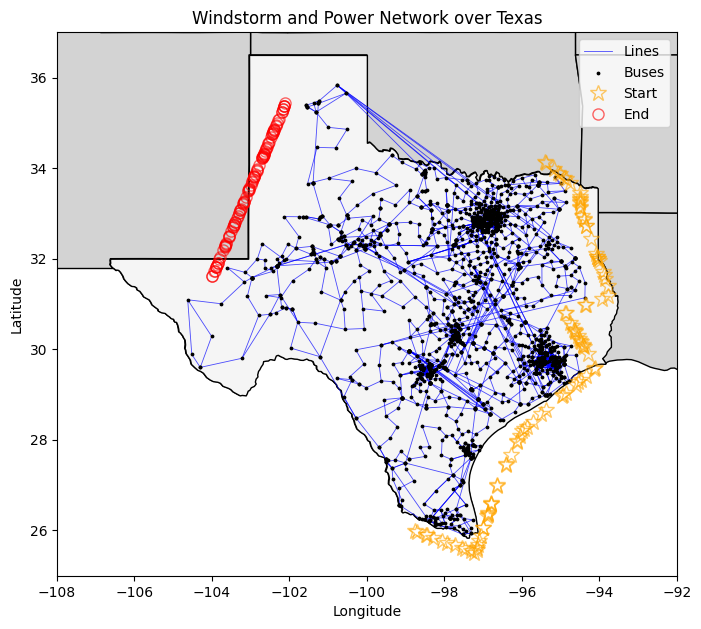

In [ ]:
# --- Plot base maps ---"
fig, ax = plt.subplots(figsize=(8, 8))
ws.plot_base(ax, net)

for i in range(100):
    ax.plot(Lon[i], Lat[i], '*', markersize=12, alpha=0.6, markerfacecolor='none', markeredgecolor='orange', label='Start' if i == 0 else "", zorder=4)
    ax.plot(Lon_n[i], Lat_n[i], 'o', markersize=8, alpha=0.6, markerfacecolor='none', markeredgecolor='red', label='End' if i == 0 else "", zorder=4)

ax.set(xlim=(-108, -92), ylim=(25, 37), xlabel="Longitude", ylabel="Latitude", title="Windstorm and Power Network over Texas")
ax.legend()
plt.show()

### 4.3 Visualizing the Storm
With the seed set, we can now generate a specific storm and visualize its path. The plot below shows five randomly selected trajectories from our scenario set. 

For each trajectory, the size of the plotted circle is proportional to the wind speed at that point in time, illustrating how the storm's intensity changes as it moves. This visualization helps in understanding the spatial and temporal characteristics of the hazard

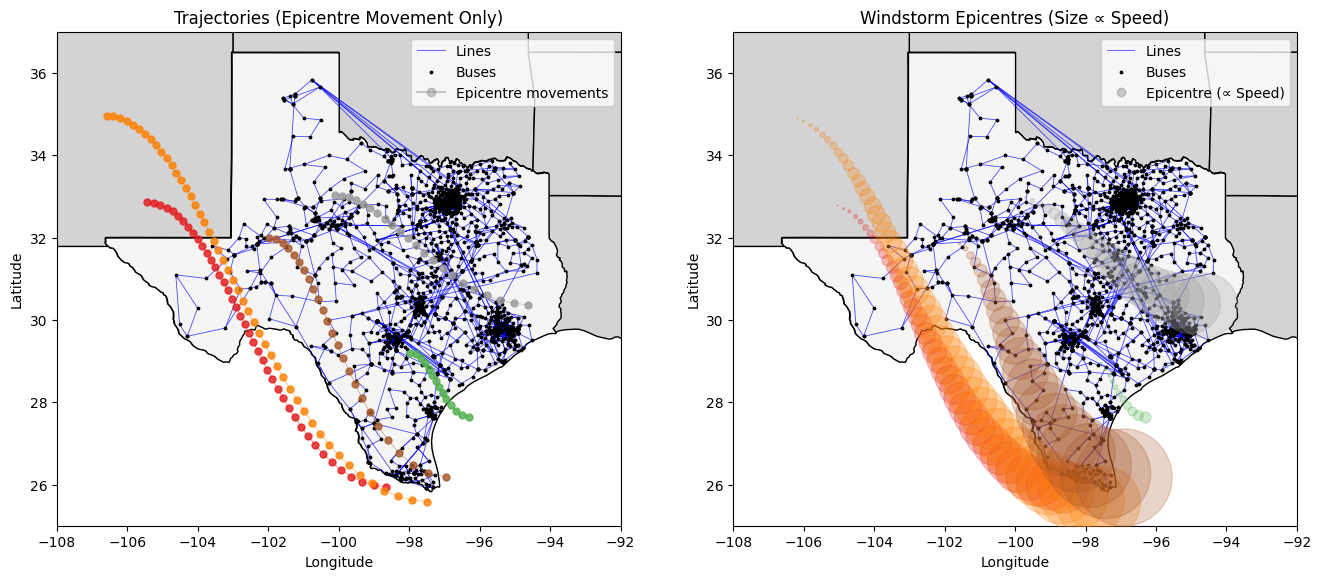


=== Windstorm Scenario Summary ===


ID,WS No.,Duration (h),Min Speed,Max Speed,Start Lon,Start Lat,End Lon,End Lat
1,1142,40,17.00,35.30,-98.65,25.95,-105.43,32.86
2,632,13,17.00,20.90,-96.30,27.64,-97.99,29.20
3,1759,47,17.00,42.90,-97.48,25.59,-106.59,34.95
4,1502,24,17.00,52.00,-96.94,26.19,-101.97,31.99
5,1530,21,17.00,40.20,-94.61,30.37,-100.11,33.03


In [5]:
# --- Plot base maps ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharex=True, sharey=True)
for ax in [ax1, ax2]:
    ws.plot_base(ax, net)

colors = plt.cm.Set1(np.linspace(0, 1, 5))
selected = random.sample(range(NumWS), 5)
storm_info = []

# --- Plot storms ---
for j, idx in enumerate(selected):
    hrs = ws._get_lng_ws()[idx]
    v_max, v_min = ws._get_lim_v_ws()[0][idx], ws._get_lim_v_ws()[1][idx]
    path = ws._crt_ws_path(Lon[idx], Lat[idx], Lon_n[idx], Lat_n[idx], v_max, hrs)
    v_scaled = np.array(ws._crt_ws_v([v_max, v_min], hrs))
    v_scaled = 2 * (v_scaled - v_scaled.min() + 1e-3)

    storm_info.append({"ID": j + 1, "WS No.": idx, "Duration (h)": hrs, "Min Speed": round(v_min, 1), "Max Speed": round(v_max, 1),
        "Start Lon": round(Lon[idx], 2), "Start Lat": round(Lat[idx], 2), "End Lon": round(path[hrs][0], 2), "End Lat": round(path[hrs][1], 2) })

    # Epicentre plot
    for t in range(hrs): ax2.plot(path[t][0], path[t][1], 'o', markersize=v_scaled[t], color=colors[j], alpha=0.25, zorder=4)
    # Trajectory plot
    xs, ys = zip(*path)
    ax1.plot(xs, ys, '-', color=colors[j], lw=0.5, alpha=0.6, zorder=4)
    ax1.plot(xs, ys, 'o', color=colors[j], markersize=5, alpha=0.8, zorder=5)

# --- Final touches ---
for ax in [ax1, ax2]:
    ax.set(xlim=(-108, -92), ylim=(25, 37), xlabel="Longitude", ylabel="Latitude")
ax1.set_title("Trajectories (Epicentre Movement Only)")
ax1.plot([], [], 'o-', color='grey', markersize=6, alpha=0.4, label='Epicentre movements')
ax2.set_title("Windstorm Epicentres (Size ∝ Speed)")
ax2.plot([], [], 'o', color='grey', markersize=6, alpha=0.4, label='Epicentre (∝ Speed)')
ax1.legend()
ax2.legend()
ax2.yaxis.set_tick_params(labelleft=True)
plt.show()

# --- Colour-coded storm info table ---
rgba_to_hex = lambda rgba: "#{:02x}{:02x}{:02x}".format(*(int(255*x) for x in rgba[:3]))
df = pd.DataFrame(storm_info)
df["Color"] = [rgba_to_hex(c) for c in colors[:len(df)]]
def highlight(row): 
    return [f"color: {df.loc[row.name, 'Color']}"] * len(row)

formats = {**{k: "{}" for k in ["ID", "WS No.", "Duration (h)"]}, **{k: "{:.2f}" for k in ["Max Speed", "Min Speed", "Start Lon", "Start Lat", "End Lon", "End Lat"]}}

styled = (df.drop(columns="Color").style.apply(highlight, axis=1).format(formats).hide(axis="index"))
print("\n=== Windstorm Scenario Summary ===")
display(HTML(styled.to_html()))

### Appendix: Geographical Distance Calculations
This section describes the mathematical formulae used to calculate geographical distances between two points, to determine the bearing from one point to another, and to determine the destination point given a starting point, distance and bearing
#### Distance
Based on the Haversine formula

$$ a = sin ^2 (\Delta \phi /2) + cos \phi _2  cos \phi_2 sin^2(\Delta \lambda/2)$$

$$ c = 2 atan \left( \sqrt{(a)}, sqrt{(1-a)} \right)$$

$$ d = Rc$$

where $d$ is the distance between two coordinates, and $R$ is the radius of the earth (6371 km).

In [6]:
d = ws._getDistance(-2.0, 55.8, -3.3, 55)
print('Distance: %.4f m'%d)

Distance: 121.0368 m


#### Bearing

The geographical bearing based on a starting point and an end point can be calculated using the formula:

$$ \theta = \text{atan2}\left( \sin \Delta\lambda \cdot \cos \phi_2, \cos \phi_1 \cdot \sin \phi_2 - \sin \phi_1 \cdot \cos \phi_2 \cdot \cos \Delta\lambda \right) $$ 

where $\phi_1, \lambda_1$  is the start point, $\phi_2, \lambda_2$ is the end point and $\Delta\lambda$ is the difference in longitude.



In [7]:
b = ws._getBearing(-2.0, 55.8, -3.3, 55)
print('Bearing: %.4f rad'%b)

Bearing: 3.8962 rad


#### Destination Point
Given a starting point [$\phi_1, \lambda_1$], an initial bearing $\alpha_1$, and a distance $s$, the destination of a journey along a great circle arc (the shortest distance) can be calculated using Vincenty's formulae:

$$ \phi_2 = \text{atan2}\left( {\sin U_1 \cdot \cos \sigma + \cos U_1 \cdot \sin \sigma \cdot \cos \alpha_1}, {(1-f) \cdot \sqrt{\sin^2 \alpha + (\sin U_1 \cdot \sin \sigma - \cos U_1 \cdot \cos \sigma \cdot \cos \alpha_1)^2}} \right) $$ 

$$ \lambda_2 = \lambda_1 +  \lambda - (1 - C)f\sin\alpha\left\{\sigma + C\sin\sigma\left[\cos(2\sigma_m) + C\cos\sigma\left(-1 + 2\cos^2(2\sigma_m)\right)\right]\right\} $$ 

In [8]:
destination = ws._getDestination(-2.0, 55.8, 0.785398, 2000)
print(f"Destination Coordinates: Longitude = {destination[0]:.2f}, Latitude = {destination[1]:.2f}")

Destination Coordinates: Longitude = -1.98, Latitude = 55.81
